# kNN regression, Support Vector Machines, and Feature Preprocessing

In [1]:
# Importing our libraries
import pandas as pd
import altair as alt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_validate, train_test_split

# import sys
# sys.path.append('code/')
# from display_tree import display_tree
from plot_classifier import plot_classifier
import matplotlib.pyplot as plt

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

## Lecture Learning Objectives 

- Explain kNN for regression.
- Explain the concept of SVMs
- Use SVMs with the RBF kernel.
- Identify when to implement feature transformations such as imputation and scaling.
- Describe the difference between normalizing and standardizing and be able to use scikit-learn's `MinMaxScaler()` and `StandardScaler()` to pre-process numeric features.
- Apply `sklearn.pipeline.Pipeline` to build a machine learning pipeline.
- Use `sklearn` for applying numerical feature transformations to the data.
- Discuss the golden rule in the context of feature transformations.

## Five Minute Recap/ Lightning Questions 

- When using a Dummy Regressor what value does the model predict for unseen data? 
- When using a Dummy Classifier (the one we examined in lecture) what class does the model predict for unseen data? 
- What is the name of the distance metric used in the $k$-nn model we looked at?
- If a dataset has 14 features and 1 target column, how many dimensions will the feature vector be?
- What is the hyperparameter name of the $k$-nn classifier we looked at last lecture?

### Some lingering questions

- How does a $k$-nn Regressor work?
- Are we ready to do machine learning on real-world datasets?
- We've looked at data with numeric features but what do we do if we have features with categories or string values?
- What happens if we are missing data in our features?
- Is there a cleaner way to do all the steps we need to do? 

## Regression with $k$-NN 

In $k$-nearest neighbour regression, we take the average of $k$-nearest neighbours instead of the majority vote.

Let's look at an example. 

Here we are creating some synthetic data with fifty examples and only one feature. 

We only have one feature of `length` and our goal is to predict `weight`. 

Regression plots more naturally in 1D, classification in 2D, but of course we can do either for any $d$

Right now, do not worry about the code and only focus on data and our model. 

In [2]:
np.random.seed(0)
n = 50
X_1 = np.linspace(0,2,n)+np.random.randn(n)*0.01
X = pd.DataFrame(X_1[:,None], columns=['length'])
X.head()

,length
0,0.017641
1,0.044818
2,0.091420
3,0.144858
4,0.181941


In [3]:
y = abs(np.random.randn(n,1))*2 + X_1[:,None]*5
y = pd.DataFrame(y, columns=['weight'])
y.head()

,weight
0,1.879136
1,0.997894
2,1.478710
3,3.085554
4,0.966069


In [4]:
snake_X_train, snake_X_test, snake_y_train, snake_y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Now let's visualize our training data. 

In [5]:
source = pd.concat([snake_X_train, snake_y_train], axis=1)

scatter = alt.Chart(source, width=500, height=300).mark_point(filled=True, color='green').encode(
    alt.X('length:Q'),
    alt.Y('weight:Q'))

scatter

alt.Chart(...)

Now let's try the $k$-nearest neighbours regressor on this data. 

Then we create our `KNeighborsRegressor` object with `n_neighbors=1` so we are only considering 1 neighbour and with `uniform` weights (the default).

In [6]:
from sklearn.neighbors import KNeighborsRegressor

knnr_1 = KNeighborsRegressor(n_neighbors=1)
knnr_1.fit(snake_X_train,snake_y_train);

predicted = knnr_1.predict(snake_X_train)
predicted

array([[ 4.57636104],
       [13.20245224],
       [ 3.03671796],
       [10.74123618],
       [ 1.82820801],
       [ 0.99789449],
       [ 1.40502866],
       [ 6.65854422],
       [10.79334171],
       [ 5.8161302 ],
       [ 8.14709171],
       [ 3.88147008],
       [10.94245294],
       [ 7.05000467],
       [ 2.02594736],
       [ 5.41216429],
       [ 9.96904766],
       [ 3.08555393],
       [ 7.12642094],
       [ 9.66684202],
       [ 0.96606889],
       [ 6.60040677],
       [ 9.76601245],
       [ 3.2341883 ],
       [10.82632705],
       [ 6.39894271],
       [ 7.97098907],
       [10.05297199],
       [ 2.58274695],
       [ 7.41754784],
       [ 9.70814143],
       [ 6.8118191 ],
       [ 8.90266502],
       [ 3.93873703],
       [ 4.38469435],
       [ 9.87724094],
       [ 9.89788429],
       [ 6.41402974],
       [ 1.47871044],
       [10.57491609]])

If we scored over regressors we get this perfect score of one since we have `n_neighbors=1` we are likely to overfit.

In [7]:
knnr_1.score(snake_X_train, snake_y_train)  

1.0

Plotting this we can see our model is trying to get every example correct since n_neighbors=1. (the mean of 1 point is just going to be the point value)

/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/tmp/ipykernel_701289/2889281394.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(snake_X_train, snake_y_train, ".r", markersize=10, color='green')


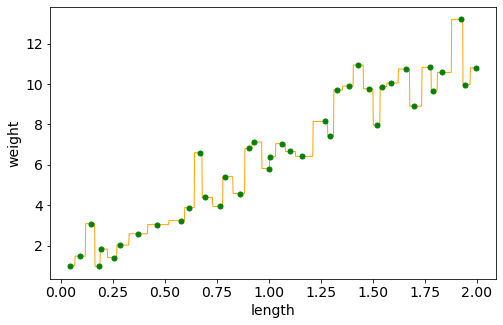

In [8]:
plt.figure(figsize=(8, 5))
grid = np.linspace(np.min(snake_X_train), np.max(snake_X_train), 1000)
plt.plot(grid, knnr_1.predict(grid), color='orange', linewidth=1)
plt.plot(snake_X_train, snake_y_train, ".r", markersize=10, color='green')
plt.xticks(fontsize= 14);
plt.yticks(fontsize= 14);
plt.xlabel("length",fontsize= 14)
plt.ylabel("weight",fontsize= 14);

What happens when we use `n_neighbors=10`?

In [9]:
knnr_10 = KNeighborsRegressor(n_neighbors=10, weights="uniform")
knnr_10.fit(snake_X_train, snake_y_train)
knnr_10.score(snake_X_train, snake_y_train)

0.9254540554756747

 Now we can see we are getting a lower score over the training set. Our score decreased from 1.0 when to had `n_neighbors=1` to now having a score of 0.925.  

When we plot our model, we can see that it no longer is trying to get every example correct. 

/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/tmp/ipykernel_701289/3006408244.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(snake_X_train, snake_y_train, ".r", markersize=10, color='green')


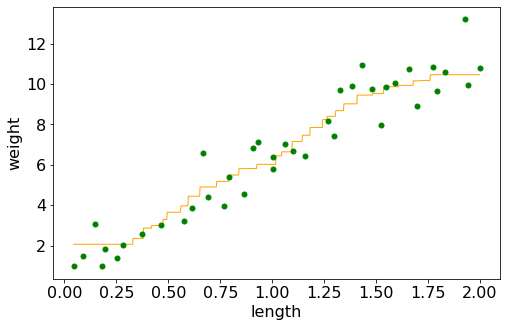

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(grid, knnr_10.predict(grid), color='orange', linewidth=1)
plt.plot(snake_X_train, snake_y_train, ".r", markersize=10, color='green')
plt.xticks(fontsize= 16);
plt.yticks(fontsize= 16);
plt.xlabel("length",fontsize= 16)
plt.ylabel("weight",fontsize= 16);

## Pros and Cons of 𝑘 -Nearest Neighbours


### Pros:

- Easy to understand, interpret.
- Simply hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to `fit`

<br>

### Cons:

- Can potentially be VERY slow during prediction time. 
- Often not that great test accuracy compared to the modern approaches.
- Need to scale your features.

## Let's Practice

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$ if we were doing regression rather than classification?


```{admonition} Solutions!
:class: dropdown

1. 1/3 ($\frac{0 + 0 + 0}{3}$) 
```

## Support Vector Machines (SVMs) with RBF Kernel

Another popular similarity-based algorithm is Support Vector Machines (SVM).

Conceptually,
SVMs try to compute which is the best linear decision boundary that can be drawn to separate two (or more) classes.
For data in 2D this would be a line, in 3D it would be a plane/surface and so on.
A general name for this decision boundary is a hyperplane.

With the training data points below ([images in the intro are from this article](https://iaviral.medium.com/what-is-support-vector-machine-svm-c1b759db65ba)),
there are multiple linear lines/hyperplanes that we could draw that would perfectly
separate the points.

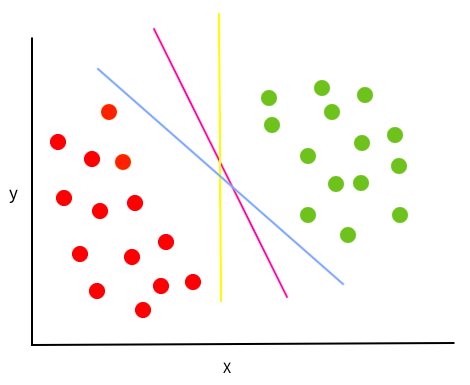

So which one is best?
SVMs define "best" as the one with the largest margin to the points from both classes.
In other words, the line that are the most in the middle of the border points in each cluster.
Since the location of the best margin only depends on the border points from each cluster,
these points are called "support points/vectors" (hence the name "support vector machines").

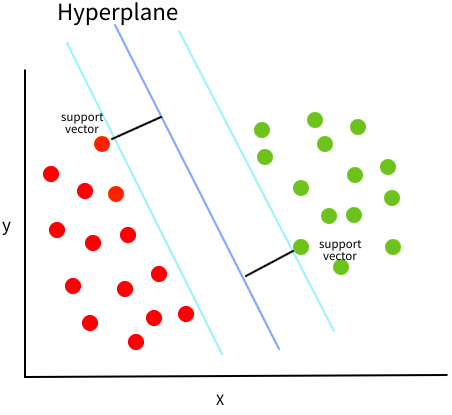

Conceptually it makes sense that the line in the middle of both the clusters is chosen,
since we would expect this border to best separate unseen data points.
If we instead put the border really close to the green or red cluster,
we might make a miss-classification on the new data points if they are not in the exact same spots as the training data.
However,
we also don't want one outlier in the training data to completely change the border
and we have hyperparameters that can control this as we will see soon.

What happens if there is no linear boundary that can be drawn to separate the data
as with the points below?

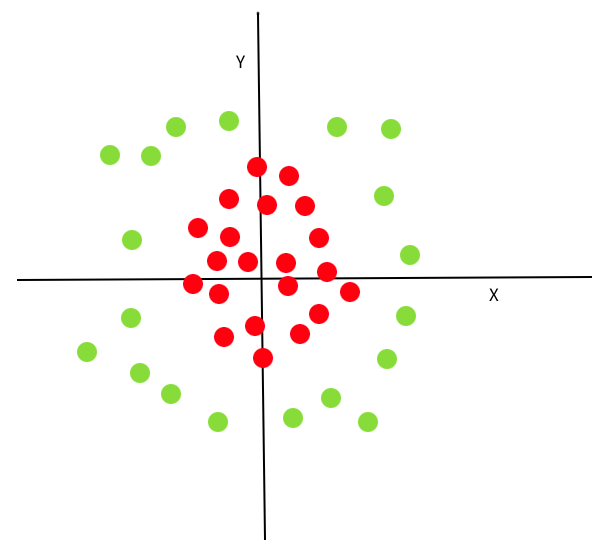

A key concept of SVMs is the transformation of existing dimensions into new ones,
where a linear decision boundary can be found.
The transformation function is referred to as a kernel,
and in this case,
we could use a polynomial kernel to create a new dimension such that $z = x^2 + y^2$.
If we plot x (or y) vs z, we can see that there is a linear decision boundary in this new dimension,
which perfectly separates the points.

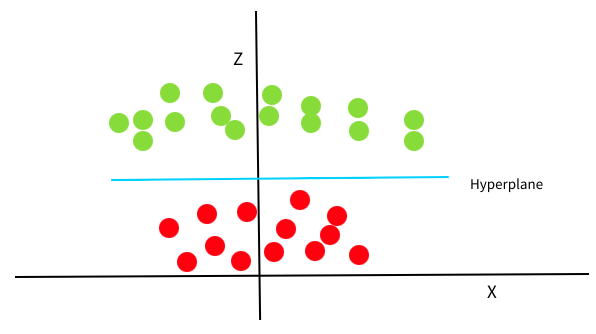

If we transform this decision boundary back to our original xy-space,
we can see that it has the shape of a ring.
([Here is an animation of this process to help you visualize it](https://www.youtube.com/watch?v=OdlNM96sHio&t=0s)).

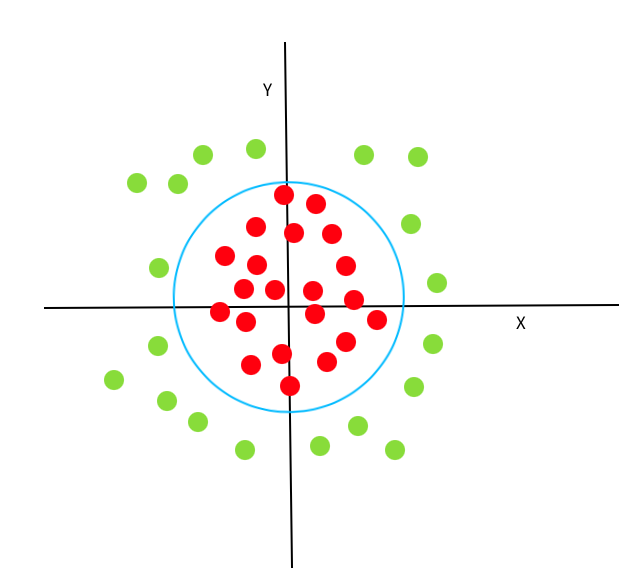

Kernel transformations allows us to use SVMs on data with complex non-linear decision borders in the original data dimensions.
Here, we are going to concentrate on the specific kernel called Radial Basis Functions (RBFs),
which is one of the most common and effective kernels
and also the default in scikit-learn.

Let's start by reading in out Canadian and USA cities data yet again.

In [11]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
cities_train_df, cities_test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
cities_train_df

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada
...,...,...,...
17,-76.3305,44.1255,USA
98,-74.7287,45.0184,Canada
66,-121.4944,38.5816,USA
126,-79.5656,43.6436,Canada


In [12]:
cities_X_train = cities_train_df.drop(columns=['country'])
cities_y_train = cities_train_df['country']
cities_X_test = cities_test_df.drop(columns=['country'])
cities_y_test = cities_test_df['country']

cities_X_train

,longitude,latitude
160,-76.4813,44.2307
127,-81.2496,42.9837
169,-66.0580,45.2788
188,-73.2533,45.3057
187,-67.9245,47.1652
...,...,...
17,-76.3305,44.1255
98,-74.7287,45.0184
66,-121.4944,38.5816
126,-79.5656,43.6436


In [13]:
cities_y_train

160    Canada
127    Canada
169    Canada
188    Canada
187    Canada
        ...  
17        USA
98     Canada
66        USA
126    Canada
109    Canada
Name: country, Length: 167, dtype: object

We can use our training feature table ($X$) and target ($y$) values by using this new SVM model with (RBF) but with the old set up with `.fit()` and `.score()` that we have seen time and time again. 

We import the `SVC` tool from the `sklearn.svm` library (The "C" in SVC represents  *Classifier*). 
To import the regressor we import `SVR` - R for *Regressor*)

In [14]:
from sklearn.svm import SVC

We can cross-validate and score exactly how we have done it in previous lectures.

In [15]:
svm = SVC()
scores = cross_validate(svm, cities_X_train, cities_y_train, return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_score,train_score
0,0.002240,0.001367,0.735294,0.714286
1,0.001958,0.001234,0.705882,0.714286
2,0.001712,0.001071,0.636364,0.761194
3,0.001775,0.001104,0.696970,0.723881
4,0.001784,0.001022,0.696970,0.626866


In [16]:
svm_cv_score = scores_df.mean()
svm_cv_score

fit_time       0.001894
score_time     0.001159
test_score     0.694296
train_score    0.708102
dtype: float64

That validation accuracy does not look too great,
let's have a look at the decision boundary.

/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<AxesSubplot:>

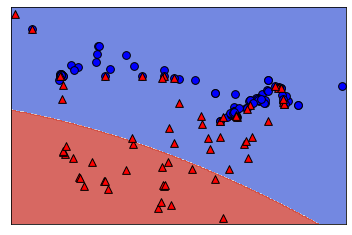

In [17]:
svm.fit(cities_X_train, cities_y_train)

plot_classifier(cities_X_train, cities_y_train, svm, ax=plt.gca())

It seems like our model is quite simple,
in other words,
it is underfitting
and not using enough of the specific structure of the training data to draw the decision boundary.

To draw a more specific boundary,
we need to tune the SVM hyperparameters.

### Hyperparameters of SVM

There are  2 main hyperparameters for support vector machines with an RBF kernel;

- `C`
- `gamma` 
    
In short, `C` is the cost/penalty the model accepts for wrongly classified examples in the training data;
it trades off correct classification of training examples against maximization of the decision function’s margin.
A lower C will reduce the cost/penalty of incorrectly classifying training data,
which allows the SVM can be more lenient and draw a simpler decision boundary that likely generalizes better,
even if that means getting a few training examples incorrect.

The gamma parameter is specific to the RBF kernel and defines how far the influence of a single training point reaches when constructing the decision boundary.
Low values mean ‘far’, creating a simple decision boundary with low curvature (at really low "gamma", the RBF kernel behaves as a linear SVM kernel).
High values mean ‘close’, creating a complex decision boundary with high curvature. 
Another way of thinking of this is that if you have two dimensional points,
and want to construct a third dimension to separate them,
gamma controls the shape of the "peaks" when the points are raised.
A large gamma gives pointed bumps in the higher dimensions,
whereas a small gamma gives a softer, broader bumps.

You can read more [in this article](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167) 
and in the [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

#### `gamma` and the fundamental trade-off

`gamma` controls the complexity of a model, just like other hyperparameters we've seen.

- higher gamma, higher the complexity.
- lower gamma, lower the complexity.

/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


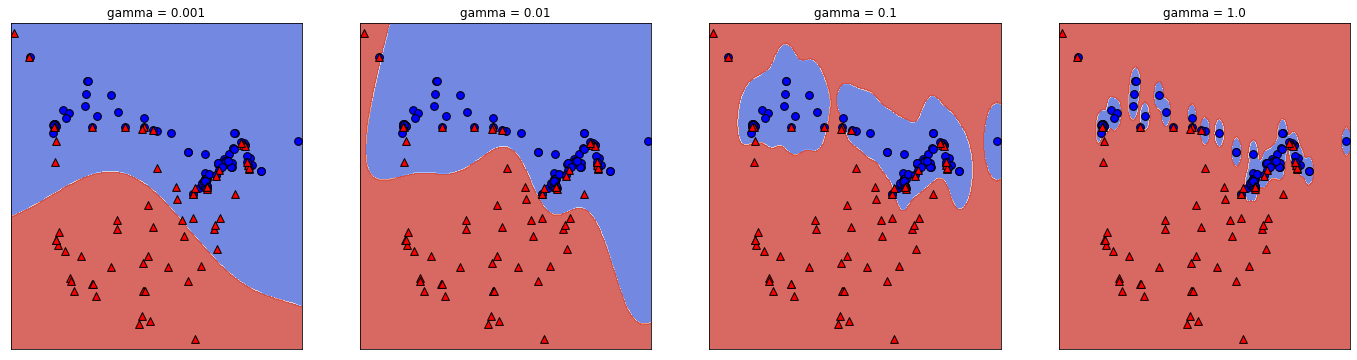

In [18]:
plt.figure(figsize=(24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    gamma = 10.0 ** (i - 3)
    rbf_svm = SVC(gamma=gamma)
    rbf_svm.fit(cities_X_train, cities_y_train)
    plt.title("gamma = %s" % gamma);
    plot_classifier(cities_X_train, cities_y_train, rbf_svm, ax=plt.gca())

#### `C` and the fundamental trade-off

`C` also controls the complexity of a model and in turn the fundamental tradeoff.

- higher `C` values, higher the complexity.
- lower `C` values, lower the complexity.

/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/joel/miniconda3/envs/bait/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


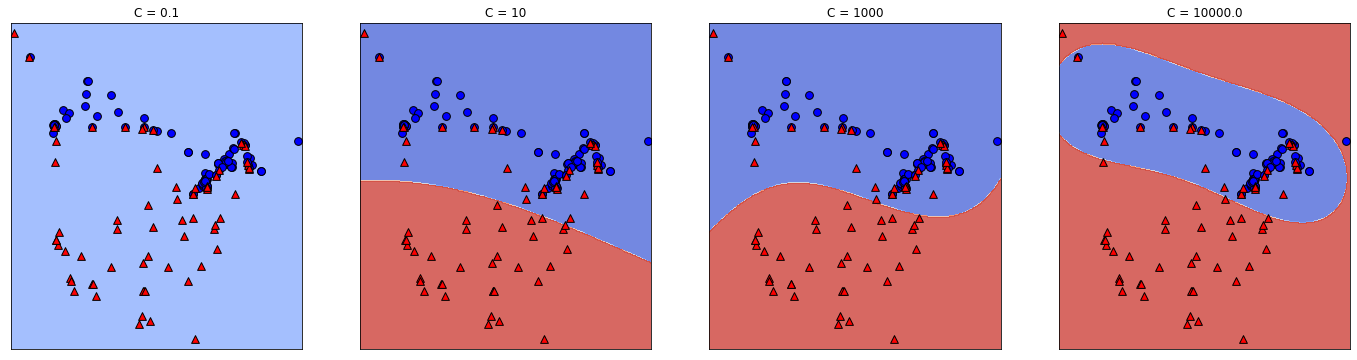

In [19]:
plt.figure(figsize=(24, 6))
for i, C in zip(range(4), [0.1, 10, 1000, 10000.0]):
    plt.subplot(1, 4, i + 1)
    rbf_svm = SVC(C=C)
    rbf_svm.fit(cities_X_train, cities_y_train)
    plt.title("C = %s" % C);
    plot_classifier(cities_X_train, cities_y_train, rbf_svm, ax=plt.gca())

Obtaining optimal validation scores requires a hyperparameter search between both `gamma` and `C` to balance the fundamental trade-off.
We will learn how to search over multiple hyperparameters at a time in lecture 5. 

## Let's Practice

**True or False** 

1. In Scikit Learn’s SVC classifier, large values of gamma tend to result in higher training scores but probably lower validation scores.     
2. If we increase both `gamma` and `C`, we can't be certain if the model becomes more complex or less complex.


```{admonition} Solutions!
:class: dropdown

1. True
2. False
```

## Let's Practice - Coding

Below is some starter code that creates your feature table and target column from the data from the `bball.csv` dataset (in the data folder).

In [20]:
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]

# Define X and y
X = bball_df.loc[:, ['height', 'weight', 'salary']]
y = bball_df['position']

1. Split the dataset into 4 objects: `X_train`, `X_test`, `y_train`, `y_test`. Make the test set 0.2 (or the train set 0.8) and make sure to use `random_state=7`.
2. Create an `SVM` model with `gamma` equal to 0.1 and `C` equal to 10.
3. Cross-validate using cross_validate() on the objects X_train and y_train specifying the model and making sure to use 5 fold cross-validation and `return_train_score=True`.
4. Calculate the mean training and cross-validation scores.

In [21]:
# 1. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

In [22]:
model = SVC(gamma=0.1, C=10)

In [23]:
# 3. Cross-validate
scores_df = pd.DataFrame(cross_validate(model,X_train,y_train, cv=5, return_train_score=True))

In [24]:
scores_df

,fit_time,score_time,test_score,train_score
0,0.004901,0.002197,0.571429,0.994898
1,0.003920,0.002178,0.571429,0.994898
2,0.003406,0.001426,0.551020,0.994898
3,0.002506,0.001989,0.530612,1.000000
4,0.003672,0.001590,0.571429,0.994898


In [25]:
# 4. Calculate the mean training and cross-validation scores.
scores_df.mean()

fit_time       0.003681
score_time     0.001876
test_score     0.559184
train_score    0.995918
dtype: float64

## Preprocessing

### The importance of Preprocessing - An Example of Why

So far we have seen:   
 
- Models: Decision trees, 𝑘-NNs, SVMs with RBF kernel.
- Fundamentals: Train-validation-test split, cross-validation, the fundamental tradeoff, the golden rule.
 


Now ...
 
**Preprocessing**: Transforming input data into a format a machine learning model can use and understand.
 

#### Basketball dataset

Let's take a look at the `bball.csv` dataset we just used in practice.

- Let's look at the  3 feature columns `height`, `weight` and `salary`. 
- Let's see if these features can help predict the `position` basketball players is. 

In [26]:
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]
X = bball_df[['weight', 'height', 'salary']]
y =bball_df["position"]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=123)

In [27]:
X_train

,weight,height,salary
152,79.4,1.88,1588231.0
337,82.1,1.91,2149560.0
130,106.6,2.03,6500000.0
340,106.1,2.08,2961120.0
50,96.2,1.93,4861207.0
...,...,...,...
151,100.7,2.06,4464286.0
120,97.5,1.91,14057730.0
26,96.6,1.93,21000000.0
328,85.7,1.88,15643750.0


In [28]:
y_train

152    G
337    G
130    F
340    F
50     G
      ..
151    F
120    G
26     G
328    G
139    F
Name: position, Length: 245, dtype: object

First, let's see what validations scores we get if we simply predict the most occurring target value in the dataset using the dummy classifier model we saw in the last lecture.

In [29]:
dummy = DummyClassifier(strategy="most_frequent")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print('Mean training score', scores['train_score'].mean().round(2))
print('Mean validation score', scores['test_score'].mean().round(2))

Mean training score 0.57
Mean validation score 0.57


Here we get a mean validation score for our 5 fold cross_validation (5 is the default) of 57%. Let's now see how much better a $k$-nn model does on the data. We saw that it doesn't do to well on SVM, let's see if there is a difference with $k$-nn. 

In [30]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print('Mean training score', scores['train_score'].mean().round(2))
print('Mean validation score', scores['test_score'].mean().round(2))

Mean training score 0.7
Mean validation score 0.5


Ok, not the score we were hoping for. 

We are getting a worse score than the dummy classifier. This can't be right..... and it isn't and we are going to explain why!

Let's have a look at just 2 players. 

We can see the values in each column. 

In [31]:
two_players = X_train.sample(2, random_state=42)
two_players

,weight,height,salary
285,91.2,1.98,1882867.0
236,112.0,2.08,2000000.0


- The values in the `weight` column are around 100.
- The values in the `height` column are around 2.
- The values in the `salary` column are much higher at around 2 million.

Let’s now calculate the distance between the two players.

In [32]:
euclidean_distances(two_players)

array([[     0.        , 117133.00184683],
       [117133.00184683,      0.        ]])

So the distance between the players is 117133.0018.

What happens if we only consider the salary column?

In [33]:
euclidean_distances(two_players[["salary"]])

array([[     0., 117133.],
       [117133.,      0.]])

It looks like it's almost the same distance!

The distance is completely dominated by the `salary` column, the feature with the largest values and the `weight` and `height` columns are being ignored in the distance calculation. 

**Does it matter?**

Yes! The scale is based on how data was collected.

Features on a smaller scale can be highly informative and there is no good reason to ignore them.
We want our model to be robust and not sensitive to the scale.

**What about for decision trees? Did scale matter then?**

No. In decision trees we ask questions on one feature at a time and so the nodes are created independently without considering others. 


We have to scale our columns before we use our $k$-nn algorithm (and many others) so they are all using a similar range of values!

And you guessed it - Sklearn has tools called transformers for this.

We'll be using `sklearn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for this example.
We will talk about this type of preprocessing in more detail in a hot minute but for now, concentrate on the syntax. 

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()                    # Create feature transformer object, can accept hyperparameters like models can! 
scaler.fit(X_train)                          # Fitting the transformer on the train split
X_train_scaled = scaler.transform(X_train)   # Transforming the train split
X_test_scaled = scaler.transform(X_test)     # Transforming the test split

`sklearn` uses `fit` and `transform` paradigms for feature transformations. (In model building it was `fit` and `predict` or `score`)

We `fit` the transformer on the train split and then `transform` the train split as well as the test split.

In [36]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,weight,height,salary
0,-1.552775,-1.236056,-0.728809
1,-1.257147,-0.800950,-0.670086
2,1.425407,0.939473,-0.214967
3,1.370661,1.664650,-0.585185
4,0.286690,-0.510879,-0.386408
...,...,...,...
240,0.779404,1.374579,-0.427932
241,0.429030,-0.800950,0.575680
242,0.330487,-0.510879,1.301942
243,-0.862975,-1.236056,0.741601


Now if we look at our features they are all within the same scales as opposed to what it was before: 

In [37]:
X_train

,weight,height,salary
152,79.4,1.88,1588231.0
337,82.1,1.91,2149560.0
130,106.6,2.03,6500000.0
340,106.1,2.08,2961120.0
50,96.2,1.93,4861207.0
...,...,...,...
151,100.7,2.06,4464286.0
120,97.5,1.91,14057730.0
26,96.6,1.93,21000000.0
328,85.7,1.88,15643750.0


### Sklearn's *predict* vs *transform*

When we make models, we `fit` and `predict`(`score`) with the syntax: 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
```

With preprocessing, we replace the `.predict()` step with a `.transform()` step. We can pass `y_train` in `fit` but it's usually ignored. It allows us to pass it just to be consistent with the usual usage of `sklearn`'s `fit` method.  

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
```


We can also carry out fitting and transforming in one call using `.fit_transform()`, but we must be mindful to use it only on the train split and **NOT** on the test split.

```
X_train_transformed = transformer.fit_transform(X_train)
```

Let's scale our features for this basketball dataset and then compare the results with our original score without scaling. 

In [38]:
knn_unscaled = KNeighborsClassifier()
knn_unscaled.fit(X_train, y_train);
print('Train score: ', (knn_unscaled.score(X_train, y_train).round(2)))
print('Test score: ', (knn_unscaled.score(X_test, y_test).round(2)))

Train score:  0.71
Test score:  0.45


In [39]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train);
print('Train score: ', (knn_scaled.score(X_train_scaled, y_train).round(2)))
print('Test score: ', (knn_scaled.score(X_test_scaled, y_test).round(2)))

Train score:  0.94
Test score:  0.89


The scores with scaled data are now much better compared to the unscaled data in the case of 𝑘-NNs.

We can see now that 𝑘-NN is doing better than the Dummy Classifier when we scaled our features. 
 
We are not carrying out cross-validation here for a reason that we'll look into soon.

### Common preprocessing techniques

Here are some commonly performed feature transformation techniques we will focus on in this lesson. 
- Imputation 
    - Tackling missing values
- Scaling 
    - Scaling of numeric features

## Let's Practice

1. Name a model that will still produce meaningful predictions with different scaled column values.     
2. Complete the following statement with one of the alternatives below: Preprocessing is done ______.        
    a) To the model but before training    
    b) To the data before training the model     
    c) To the model after training     
    d) To the data after training the model    
3. `StandardScaler` is a type of what?    

**True or False**    
 
4\. Columns with lower magnitudes compared to columns with higher magnitudes are less important when making predictions.      
5\. A model less sensitive to the scale of the data makes it more robust.   


```{admonition} Solutions!
:class: dropdown

1. Decision Tree Algorithm
2. b) To the data before training the model
3. Transformer
4. False
5. True

```

## California housing data (A case study) 

For the next few examples of preprocessing,  we are going to be using a dataset exploring the prices of homes in California to demonstrate feature transformation techniques.  The data can be downloaded from this site [here](https://www.kaggle.com/harrywang/housing). Please make sure that you include it in your `data` folder that resides in `lectures`. 

This dataset is a modified version of the California Housing dataset available from [Luís Torgo's University of Porto website](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)


The task is to predict median house values in California districts, given several features from these districts. 


In [40]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,167600.0,<1H OCEAN
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,180900.0,<1H OCEAN
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,286200.0,<1H OCEAN
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY


Some column values are mean/median but some are not.

Before we use this data we need to do some **feature engineering**. 

That means we are going to transform our data into features that may be more meaningful for our prediction.

Let's add some new features to the dataset which could help predict the target: `median_house_value`.

In [41]:
train_df = train_df.assign(rooms_per_household = train_df["total_rooms"]/train_df["households"],
                           bedrooms_per_household = train_df["total_bedrooms"]/train_df["households"],
                           population_per_household = train_df["population"]/train_df["households"])

test_df = test_df.assign(rooms_per_household = test_df["total_rooms"]/test_df["households"],
                         bedrooms_per_household = test_df["total_bedrooms"]/test_df["households"],
                         population_per_household = test_df["population"]/test_df["households"])

train_df = train_df.drop(columns=['total_rooms', 'total_bedrooms', 'population'])  
test_df = test_df.drop(columns=['total_rooms', 'total_bedrooms', 'population']) 

train_df

,longitude,latitude,housing_median_age,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,130.0,3.6389,167600.0,<1H OCEAN,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,779.0,4.5391,180900.0,<1H OCEAN,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,697.0,5.6306,286200.0,<1H OCEAN,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,326.0,3.8750,412500.0,NEAR BAY,4.739264,1.024540,1.720859


### When is it OK process the data before splitting of the test portion? 

- Here it would have been OK to add new features before splitting because we are not using any global information in the data but only looking at one row at a time. 
- But just to be safe and to avoid accidentally breaking the golden rule, it's better to do it after splitting. 

## Preprocessing: Imputation 

Imputation is handling missing values in our data so let's explore this a little. 

We can `.info()` we can we all the different column dtypes and also all the number of null values.

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 6051 to 19966
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   households                18576 non-null  float64
 4   median_income             18576 non-null  float64
 5   median_house_value        18576 non-null  float64
 6   ocean_proximity           18576 non-null  object 
 7   rooms_per_household       18576 non-null  float64
 8   bedrooms_per_household    18391 non-null  float64
 9   population_per_household  18576 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We see that we have all columns with dtype `float64` except for `ocean_proximity` which appears categorical.

We also notice that the `bedrooms_per_household` column appears to have some `Non-Null` rows (ie missing values). 

In [43]:
train_df["bedrooms_per_household"].isnull().sum()

185

Knowing this information let's build a model. 

When we create our feature table and target objects, we are going to drop the categorical variable `ocean_proximity`.  Currently, we don't know how to build models with categorical data, but we will shortly. We will return to this column soon. 

In [44]:
X_train = train_df.drop(columns=["median_house_value", "ocean_proximity"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "ocean_proximity"])
y_test = test_df["median_house_value"]

knn = KNeighborsRegressor()

What happens when we try to fit our model with this data?

In [45]:
knn.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

> `Input contains NaN, infinity or a value too large for dtype('float64').`

The classifier can't deal with missing values (NaNs).

How can we deal with this problem? 

### Why we don't drop the rows 

We could drop any rows that are missing information but that's problematic too. 

Then we would need to do the same in our test set.

And what happens if we get missing values in our deployment data? what then?

Furthermore, what if the missing values don't occur at random and we're systematically dropping certain data?
Perhaps a certain type of house contributes to more missing values. 

Dropping the rows is not a great solution, especially if there's a lot of missing values.

In [46]:
X_train.shape

(18576, 8)

In [47]:
X_train_no_nan = X_train.dropna()
X_train_no_nan.shape

(18391, 8)

### Why we don't drop the column 

If we drop the column instead of the rows, we are throwing away, in this case, 18391 values just because we don't have 185 missing values out of a total of 18567. 

We are throwing away 99% of the column’s data because we are missing 1%.

But perhaps if we were missing 99.9% of the column values, for example, it would make more sense to drop the column.


In [48]:
X_train.shape

(18576, 8)

In [49]:
X_train_no_col = X_train.dropna(axis=1)
X_train_no_col.shape

(18576, 7)

### Why we use imputation 

With **Imputation**, we invent values for the missing data.

Using `sklearn`'s **transformer** `SimpleImputer`, we can impute the `NaN` values in the data with some value. 

In [50]:
from sklearn.impute import SimpleImputer

We can impute missing values in:

- **Categorical columns**: 
    - with the most frequent value 
    - with a constant of our choosing.
- **Numeric columns**: 
    - with the mean  of the column
    - with the median of the column 
    - or a constant of our choosing.

If I sort the values by `bedrooms_per_household` and look at the end of the dataframe, we can see our missing values in the `bedrooms_per_household` column. 

Pay close attention to index 7763 since we are going to look at this row after imputation. 

In [51]:
X_train.sort_values('bedrooms_per_household').tail(10)

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
18786,-122.42,40.44,16.0,181.0,2.1875,5.491713,NaN,2.734807
17923,-121.97,37.35,30.0,386.0,4.6328,5.064767,NaN,2.588083
16880,-122.39,37.59,32.0,715.0,6.1323,6.289510,NaN,2.581818
4309,-118.32,34.09,44.0,726.0,1.6760,3.672176,NaN,3.163912
538,-122.28,37.78,29.0,1273.0,2.5762,4.048704,NaN,2.938727
4591,-118.28,34.06,42.0,1179.0,1.2254,2.096692,NaN,3.218830
19485,-120.98,37.66,10.0,255.0,0.9336,3.662745,NaN,1.572549
6962,-118.05,33.99,38.0,357.0,3.7328,4.535014,NaN,2.481793
14970,-117.01,32.74,31.0,677.0,2.6973,5.129985,NaN,3.098966
7763,-118.10,33.91,36.0,130.0,3.6389,5.584615,NaN,3.769231


Using the same `fit` and `transform` syntax we saw earlier for transformers, we can impute the `NaN` values. 

Here we specify `strategy="median"` which replaces all the missing values with the column median. 

We fit on the training data and transform it on the train and test splits. 


In [52]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train);
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

In [53]:
X_train_imp

array([[-117.75      ,   34.04      ,   22.        , ...,    4.89700997,
           1.05647841,    4.31893688],
       [-119.57      ,   37.94      ,   17.        , ...,   17.3       ,
           6.5       ,    2.55      ],
       [-117.13      ,   32.74      ,   46.        , ...,    4.73870056,
           1.08474576,    2.0579096 ],
       ...,
       [-121.76      ,   37.33      ,    5.        , ...,    5.95839311,
           1.03156385,    3.49354376],
       [-122.44      ,   37.78      ,   44.        , ...,    4.7392638 ,
           1.02453988,    1.7208589 ],
       [-119.08      ,   36.21      ,   20.        , ...,    5.49137931,
           1.11781609,    3.56609195]])

Ok, the output of this isn't a dataframe but a NumPy array! 

I can do a bit of wrangling here to take a look at this new array with our previous column labels and as a dataframe. 

If I search for our index 7763 which previously contained a `NaN` value, we can see that now I have the median value for the `bedrooms_per_household` column from the `X_train` dataframe. 

In [54]:
X_train_imp_df = pd.DataFrame(X_train_imp, columns = X_train.columns, index = X_train.index)
X_train_imp_df.loc[[7763]]

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
7763,-118.1,33.91,36.0,130.0,3.6389,5.584615,1.04886,3.769231


In [55]:
X_train['bedrooms_per_household'].median()

1.0488599348534202

In [56]:
X_train.loc[[7763]]

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
7763,-118.1,33.91,36.0,130.0,3.6389,5.584615,NaN,3.769231


Now when we try and fit our model using `X_train_imp`, it works!

In [57]:
knn = KNeighborsRegressor();
knn.fit(X_train_imp, y_train)
knn.score(X_train_imp, y_train)

0.5609808539232339

## Preprocessing: Scaling 

So we've seen why scaling is important earlier but let's take a little bit of a closer look here. 
There are many ways to scale your data but we are going to look at 2 of them. 


![](https://amueller.github.io/COMS4995-s19/slides/aml-05-preprocessing/images/scaler_comparison_scatter.png)

 
| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| normalization | sets range to $[0,1]$   | `X -= np.min(X,axis=0)`<br>`X /= np.max(X,axis=0)`  | [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

For more resources and articles on this, see [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).

Let's see what happens when we use each of them. 

In [58]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

First, let's see how standardization is done first. 

In [59]:
scaler = StandardScaler()
X_train_scaled_std = scaler.fit_transform(X_train_imp)
X_test_scaled_std = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled_std, columns=X_train.columns, index=X_train.index)

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
6051,0.908140,-0.743917,-0.526078,0.266135,-0.389736,-0.210591,-0.083813,0.126398
20113,-0.002057,1.083123,-0.923283,-1.253312,-0.198924,4.726412,11.166631,-0.050132
14289,1.218207,-1.352930,1.380504,0.542873,-0.635239,-0.273606,-0.025391,-0.099240
13665,1.128188,-0.753286,-0.843842,-0.561467,0.714077,0.122307,-0.280310,0.010183
14471,1.168196,-1.287344,-0.843842,2.500924,-1.059242,-0.640266,-0.190617,0.126808
...,...,...,...,...,...,...,...,...
7763,0.733102,-0.804818,0.586095,-0.966131,-0.118182,0.063110,-0.099558,0.071541
15377,1.163195,-1.057793,-1.161606,0.728235,0.357500,0.235096,-0.163397,0.007458
17730,-1.097293,0.797355,-1.876574,0.514155,0.934269,0.211892,-0.135305,0.044029
15725,-1.437367,1.008167,1.221622,-0.454427,0.006578,-0.273382,-0.149822,-0.132875


Here, any negative values represent values that are lower than the calculated feature mean and anything positive and greater than 0 are values greater than the original column mean.

In [60]:
knn = KNeighborsRegressor()
knn.fit(X_train_imp, y_train);
print('Unscaled training score :', knn.score(X_train_imp, y_train).round(3))

Unscaled training score : 0.561


In [61]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled_std, y_train)
print('Scaled training score :', knn.score(X_train_scaled_std, y_train))

Scaled training score : 0.7978563117812038


In [62]:
scaler = MinMaxScaler()
X_train_scaled_norm = scaler.fit_transform(X_train_imp)
X_test_scaled_norm = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled_norm, columns=X_train.columns, index=X_train.index).head()

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
6051,0.657371,0.159405,0.411765,0.098832,0.181039,0.028717,0.021437,0.002918
20113,0.476096,0.573858,0.313725,0.003124,0.205942,0.116642,0.182806,0.001495
14289,0.719124,0.021254,0.882353,0.116264,0.148998,0.027594,0.022275,0.001099
13665,0.701195,0.157279,0.333333,0.046703,0.325099,0.034645,0.018619,0.001981
14471,0.709163,0.036132,0.333333,0.239599,0.093661,0.021064,0.019905,0.002922


Looking at the data after normalizing it, we see this time there are no negative values and they all are between 0 and 1.

And the score now?

In [63]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled_norm, y_train)
print('Scaled training score :',knn.score(X_train_scaled_norm, y_train))

Scaled training score : 0.8006485189373813


- Big difference in the KNN training performance after scaling the data. 
- But we saw last week that the training score doesn't tell us much. We should look at the cross-validation score.

So let's see how we can do this but first.... let's practice!

## Let's Practice

1\. When/Why do we need to impute our data?   
2\. If we have `NaN` values in our data, can we simply drop the column missing the data?   
3\. Which scaling method will never produce negative values?   
4\. Which scaling method will never produce values greater than 1?    
5\. Which scaling method will produce values where the range depends on the values in the data?   

**True or False**     

6\. `SimpleImputer` is a type of transformer.      
7\. Scaling is a form of transformation.       
8\. We can use `SimpleImputer` to impute values that are missing from numerical and categorical columns.      

```{admonition} Solutions!
:class: dropdown

1. When we have missing data so that sklearn doesn't give an error. 
2. No but we can if the majority of the values are missing from the column.
3. Normalization (`MinMaxScaler`)
4. Normalization (`MinMaxScaler`)
5. Standardization (`StandardScaler`)
6. True
7. True
8. True
```

## Feature transformations and the golden rule 

How to carry out cross-validation? 

- Last week we saw that cross-validation is a better way to get a realistic assessment of the model. 
- Let's try cross-validation with transformed data. 

In [64]:
knn = KNeighborsRegressor()
scores = cross_validate(knn, X_train_scaled_std, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.011932,0.147443,0.696373,0.794236
1,0.008757,0.130968,0.684447,0.791467
2,0.008732,0.154511,0.695532,0.789436
3,0.010271,0.157842,0.679478,0.793243
4,0.008897,0.089000,0.680657,0.794820


- Do you see any problem here? 

We are using our `X_train_scaled` in our `cross_validate()` function which already has all our preprocessing done. 

<img src='imgs/cross-validation.png' width="80%">

That means that our validation set information is being used to calculate the mean and standard deviation (or min and max values for `MinMaxScaler`) for our training split! 

We are allowing information from the validation set to **leak** into the training step.
    
What was our golden rule of machine learning again? Oh yeah -> ***Our test data should not influence our training data***. 

This applies also to our validation data and that it also should not influence our training data. 

With imputation and scaling, we are scaling and imputing values based on all the information in the data meaning the training data AND the validation data and so we are not adhering to the golden rule anymore. 

Every row in our `x_train_scaled` has now been influenced in a minor way by every other row in `x_train_scaled`. 

With scaling every row has been transformed based on all the data before splitting between training and validation. 

We need to take care that we are keeping our validation data truly as unseen data. 

Before we look at the right approach to this, let's look at the **WRONG** approaches. 

### Bad methodology 1: Scaling the data separately

We make our transformer, we fit it on the training data and then transform the training data.

Then, we make a second transformer, fit it on the test data and then transform our test data.

In [65]:
scaler = StandardScaler();
scaler.fit(X_train_imp);
X_train_scaled = scaler.transform(X_train_imp)


# Creating a separate object for scaling test data - Not a good idea.
scaler = StandardScaler();
scaler.fit(X_test_imp); # Calling fit on the test data - Yikes! 
X_test_scaled = scaler.transform(X_test_imp) # Transforming the test data using the scaler fit on test data ... Bad! 


knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train);
print("Training score: ", knn.score(X_train_scaled, y_train).round(2))
print("Test score: ", knn.score(X_test_scaled, y_test).round(2))

Training score:  0.8
Test score:  0.7


This is bad because we are using two different StandardScaler objects but we want to apply the same transformation on the training and test splits.

The test data will have different values than the training data producing a different transformation than the training data.

We should never fit on test data, whether it’s to build a model or with a transforming, test data should never be exposed to the fit function.

### Bad methodology 2: Scaling the data together

The next mistake is when we scale the data together. So instead of splitting our data, we are combining our training and testing and scaling it together.

In [66]:
X_train_imp.shape, X_test_imp.shape

((18576, 8), (2064, 8))

In [67]:
# join the train and test sets back together
XX = np.vstack((X_train_imp, X_test_imp))## Don't do it! 
XX.shape 

(20640, 8)

In [68]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX) 
XX_train = XX_scaled[:18576]
XX_test = XX_scaled[18576:]

In [69]:
knn = KNeighborsRegressor()
knn.fit(XX_train, y_train);
print('Train score: ', (knn.score(XX_train, y_train).round(2))) # Misleading score
print('Test score: ', (knn.score(XX_test, y_test).round(2))) # Misleading score

Train score:  0.8
Test score:  0.71


Here we are scaling the train and test splits together.

The golden rule says that the test data shouldn’t influence the training in any way.

Information from the test split is now affecting the mean for standardization!

This is a clear violation of the golden rule.

So what do we do? Enter ....

## Pipelines

[Scikit-learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is here to save the day!

A **pipeline** is a sklearn function that contains a sequence of steps. 

Essentially we give it all the actions we want to do with our data such as transformers and models and the pipeline will execute them in steps. 

In [70]:
from sklearn.pipeline import Pipeline

Let's combine the preprocessing and model with pipeline.

we will instruct the pipeline to:

1. Do imputation using `SimpleImputer()` using a strategy of “median”
2. Scale our data using `StandardScaler` 
3. Build a `KNeighborsRegressor`. 

(The last step should be a model and earlier steps should be transformers) 

Note: The input for `Pipeline` is a list containing tuples (one for each step). 

In [71]:
pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("reg", KNeighborsRegressor())
])

In [72]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('reg', KNeighborsRegressor())])

- Note that we are passing `X_train` and **NOT** the imputed or scaled data here. 

When we call `fit`  the pipeline is carrying out the following steps:

- Fit `SimpleImputer` on `X_train`.
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`.
- Fit `StandardScaler` on `X_train_imp`.
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`.
- Fit the model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`.


In [73]:
pipe.predict(X_train)

array([126500., 117380., 187700., ..., 259500., 308120.,  60860.])

When we call `predict` on our data, the following steps are carrying out:

- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`.
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`.
- Predict using the fit model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`. 

It is not fitting any of the data this time. 


<img src='https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/images/pipeline.png' width="50%">

[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

We can’t accidentally re-fit the preprocessor on the test data as we did before.

It automatically makes sure the same transformations are applied to train and test.

Now when we do cross-validation on the pipeline the transformers and the model are refit on each fold.

The pipeline applies the `fit_transform` on the train portion of the data and only `transform` on the validation portion in **each fold**.   

This is how to avoid the Golden Rule violation!

In [74]:
scores_processed = cross_validate(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores_processed)

,fit_time,score_time,test_score,train_score
0,0.025440,0.142615,0.693883,0.792395
1,0.022569,0.137869,0.685017,0.789108
2,0.023778,0.141539,0.694409,0.787796
3,0.022253,0.144353,0.677055,0.792444
4,0.022670,0.118798,0.714494,0.823421


In [75]:
pd.DataFrame(scores_processed).mean()

fit_time       0.023342
score_time     0.137035
test_score     0.692972
train_score    0.797033
dtype: float64

In [76]:
dummy = DummyRegressor()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.001181
score_time     0.000262
test_score    -0.000838
train_score    0.000000
dtype: float64

We can trust here now that the scores are not influenced but the training data and all our steps were done efficiently and easily too. 

## Let's Practice

1\. Which of the following steps cannot be used in a pipeline?

a) Scaling   
b) Model building    
c) Imputation    
d) Data Splitting    

2\. Why can't we fit and transform the training and test data together?  

**True or False**        

3\. We have to be careful of the order we put each transformation and model in a pipeline.     
4\. Pipelines will fit and transform on both the training and validation folds during cross-validation.   

```{admonition} Solutions!
:class: dropdown

1. Data Splitting
2. It's violating the golden rule of keeping the test data separate.
3. True
4. False
```

## Let's Practice - Coding

Let's bring in the basketball dataset again.

In [77]:
# Loading in the data
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]

# Define X and y
X = bball_df.loc[:, ['height', 'weight', 'salary']]
y = bball_df['position']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

Build a pipeline named `bb_pipe` that: 
1. Imputes using "median" as a strategy, 
2. scale using `StandardScaler` 
3. builds a `KNeighborsClassifier`.


Next, do 5 fold cross-validation on the pipeline using `X_train` and `y_train` and save the results in a dataframe.
Take the mean of each column and assess your model.

## What We've Learned Today<a id="9"></a>

- How the $k$NN algorithm works for regression.
- How to build an SVM with RBF kernel model. 
- How changing `gamma` and `C` hyperparameters affects the fundamental tradeoff.
- How to imputer values when we are missing data. 
- Why it's important to scale our features.
- How to scales our features. 
- How to build a pipeline that executes a number of steps without breaking the golden rule of ML.
